In [4]:
import cvxpy as cp
from copy import deepcopy as copy
from scipy.linalg import fractional_matrix_power, block_diag
import networkx as nx
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
from operator import itemgetter
# from netgraph import InteactiveGraph # pip install netgraph
from functools import reduce
import scipy 
from numpy.linalg import matrix_rank as rank 
from utils.Adversary import Adversary
from utils.Conversions import hamming_dist as dist, to_str, visualize 
from utils.Solvers import type_mask, partial, ket, instance_mask, adv_solver
from utils.Problems import exact_k, threshold_k, Problem
from functools import reduce
from itertools import product

In [5]:
def partial_identity(size, id_size, index):
    sub_mat = np.zeros((size, size))
    sub_mat[index, index] = 1
    return np.kron(sub_mat, np.eye(id_size))

def delta_mat(x, y, lang_size):
    n = len(x)
    mat = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if x[i] == x[j]:
                mat[i,j] = 1
    loc_mat = np.zeros((lang_size, lang_size))
    loc_mat[i,j] = 1
    return np.kron(loc_mat, mat)


def partial_transpose(mat, dim1=None, dim2=None):
    assert mat.shape[0] == mat.shape[1]
    mat_size = mat.shape[0]
    if dim1 is None:
        size = int(np.sqrt(mat_size))  
        dim1 = size
        dim2 = size
        
    elif dim2 is None:
        dim2 = mat_size // dim1
    
    assert dim2 * dim1 == mat_size, ("dim1=" + str(dim1) + ", dim2=" + 
                                     str(dim2) +", mat_size=" + str(mat_size))
    
    pt_mat = cp.bmat(
        [
            [
                mat[i*dim2:(i+1)*dim2, j*dim2:(j+1)*dim2].T for i in range(dim1)
            ] for j in range(dim1)
        ]
    )

    return pt_mat
        
def ppt_span_bound(problem, p, r):
    n = problem.n
    lang_size = problem.len
    orig_size = n * lang_size
    pure_size = orig_size * r
    sep_size = pure_size * pure_size 
    print("sep_size", sep_size, pure_size, orig_size, lang_size, n)
    X = cp.Variable((sep_size, sep_size), PSD=True)
    D = [partial_identity(lang_size, n, i) for i in range(lang_size)]
    Delta = [delta_mat(inst1, inst2, problem.len) for inst1, inst2 in 
        list(product(problem.yes_instances, problem.no_instances))
        ]
    
    big_D = [reduce(np.kron, 
                    [d, np.eye(r), np.ones((pure_size, pure_size))]) - np.eye(sep_size)/lang_size for d in D]
    big_Delta = [reduce(np.kron, [mat, np.eye(r), np.ones((pure_size, pure_size))]) - p*np.eye(sep_size) for mat in Delta]
    constraints = [cp.trace(X)==1, partial_transpose(X) >> 0]
    partial_inner = partial_inner_mat([pure_size, pure_size], 0)

    constraints += [
        partial_inner @ cp.multiply(mat, X) @ partial_inner.T == 0 for mat in big_Delta
    ] 

    opt_prob = cp.Problem(cp.Minimize(0), constraints)
    opt_prob.solve(solver="SCS", verbose=True)
    return X.value

def partial_inner_mat(dims, i):
    left_I = np.eye(int(np.prod(dims[:i])))
    right_I = np.eye(int(np.prod(dims[i+1:])))
    left = reduce(np.kron, [left_I, np.ones((1, dims[i])), right_I])
    right = reduce(np.kron, [left_I, np.ones((dims[i], 1)), right_I])
    # print(big_A.shape, B.shape, left.shape, right.shape)
    return left 
#<A,B>
def inner_mats(A,B):
    C = A*B
    return (np.ones((1, A.shape[1])) @ C @  np.ones((B.shape[0], 1)))[0,0]
    
# A is dims[i] by dims[i], B is \otimes_j dims[j] square
# want to apply <A,.> to the ith component of B  

def index_pair_perms(row, col):
    return list(
        set(p for p in product([row, row[::-1]], [col, col[::-1]]))
           )
    
def inv_map(map):
    return {image: preimage for preimage, image in enumerate(map)}
    
def symmetry_projection(pairs):
    proj = np.zeros((len(pairs), len(pairs)))
    inv_pairs = inv_map(pairs)
    for pair in pairs:
        pair_i = inv_pairs[pair]
        pair_rev = pair[::-1]
        pair_rev_i = inv_pairs[pair_rev]
        if not (pair == pair_rev and pair[0] != pair[1]): 
            proj[pair_i, pair_rev_i] = 1
    return np.eye(len(pairs))/2+proj/2
    
def dual_bound(objective_mask, constraint_mask, rank):
    pass

size 4


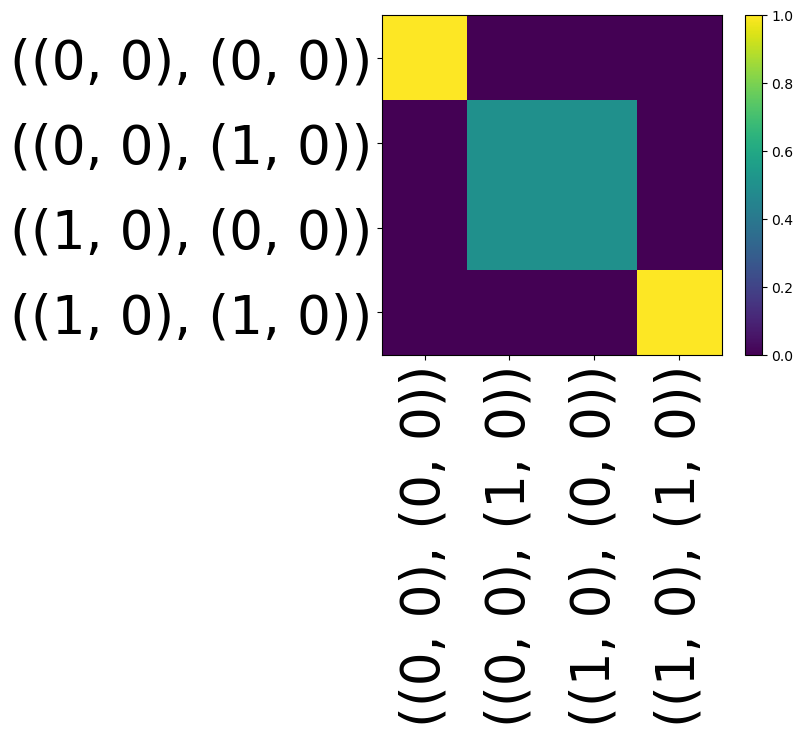

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Jan 07 06:07:55 PM: Your problem has 5 variables, 16 constraints, and 0 parameters.
(CVXPY) Jan 07 06:07:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 07 06:07:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 07 06:07:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 07 06:07:55 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 07 06:07:55 PM: Compiling problem (target solver=MOSEK).
(CV

In [6]:
n=2
def constraint_contribution(var, const_mat, const):
    rank = var.shape[0]//const_mat.shape[0]
    return cp.kron(const * np.eye(var.shape[0]), var) - cp.kron(cp.multiply(const_mat, A))

def dual_sep_bound(obj_mat, const_mat, const, rank):
    n = obj_mat.shape[0] # size of initial state
    labels = list(product(range(n), range(rank)))
    pairs = list(product(labels, labels))
    # pairs = [a + b for a,b in pairs]
    init_size = len(labels) # size of pure representation of state
    size = len(pairs) # separable size
    inv_pairs = inv_map(pairs)
    print('size', size)
    t = cp.Variable()
    A = cp.Variable((init_size, init_size))
    big_obj_mat = np.kron(obj_mat, np.eye(rank*init_size))
    rank_const_mat = np.kron(const_mat, np.eye(rank))
    witness_t = big_obj_mat - t*np.eye(size)
    witness_A = cp.kron(const * np.eye(init_size), A) - cp.kron(cp.multiply(rank_const_mat, A), np.ones((init_size, init_size))) 
    witness = witness_t + witness_A
    proj = symmetry_projection(pairs)
    # print(np.linalg.eigvals(proj))
    visualize(proj, (pairs, pairs))
    constraints = [proj @ witness @ proj >> 0]
    opt_prob = cp.Problem(cp.Maximize(t), constraints)
    opt_prob.solve(solver='MOSEK', verbose=True)
    return A.value, t.value, witness.value
    
    
obj_mat = np.array([[1, 0],
                    [0, 0]])
const_mat = np.array([[1, 1],
                      [1, -2]])
rank=1
A, t, witness = dual_sep_bound(obj_mat, const_mat, 0, rank)

[[-87334.30249757  50742.25313181]
 [ 74232.75717628  43684.0868458 ]]
0.49999911048792345


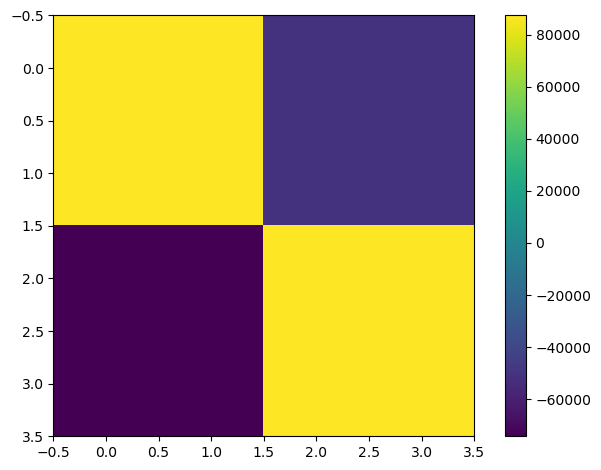

NameError: name 'proj' is not defined

In [7]:
print(A)
print(t)
visualize(witness)
visualize(proj@witness@proj)

In [ ]:
to_str((1,2))

## Example

We want to find $X$ which maximizes $X[1,1]$ such that $X[0,0]=X[0,1]$ 

In [8]:


def apply_partial(X, dim):
    assert X.shape[0] == 

def gen_sdp(obj_mat, constr_mats, consts):
    X = cp.Variable(obj_mat.shape, PSD=True)
    constraints = [cp.trace(constr_mat.T@X) == const for constr_mat, consts in zip(constr_mats, consts)]
    constraints += [cp.trace(X) == 1]
    opt_prob = cp.Problem(cp.Maximize(cp.trace(obj_mat.T@X)), constraints)
    opt_prob.solve(solver="MOSEK", verbose=True)
    return X.value

# obj_mat = np.array([[1,1,1],
#                     [1,0,0],
#                     [1,0,0]])
# C1 = np.array([[0,1,0],
#                [1,0,0],
#                [0,0,0]])
# C2 = np.array([
#     [0,0,1],
#     [0,0,0],
#     [1,0,0]])

obj_mat = np.array([[0, 1],
                    [1, 1]])
C1 = np.array([[1, 0],
               [0, -1/2]])
C2 = np.array([[0,1],
               [1,-1]])
# constr_mat = np.array([[1/3,   0],
                       # [-1,1/2]])
X = gen_sdp(obj_mat, [C1, C2], [0,0])
print(X)

np.linalg.matrix_rank(np.round(X))

SyntaxError: invalid syntax (2869608264.py, line 2)

obj [[1 0]
 [0 0]]
[array([[1, 0],
       [0, 0]])]
[0]
[[1 0]
 [0 0]]



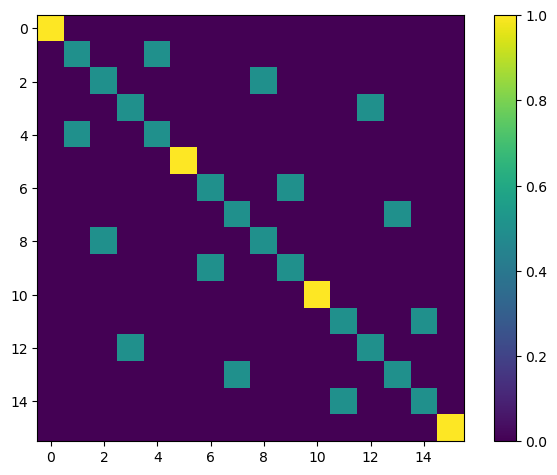

NameError: name 'inv_pair' is not defined

In [15]:
def partial_trace(X, dim):
    print(X)
    id_dim = X.shape[0] // dim
    pt = np.zeros((id_dim, id_dim))
    for i in range(dim):
        print(id_dim)
        right = cp.kron(np.array([ket(i, dim)]), np.eye(id_dim)).T
        left = right.T
        pt = pt + left @ X @ right
    return pt

# return <part, .>\otimes ID(X)
def apply_partial(X, dim, part, pairs):
    id_dim = X.shape[0] // dim
    new_X = np.zeros((id_dim, id_dim))
    # for i,j in product(range(dim), range(dim)):
    #     left = np.kron(ket(i,dim), np.eye(id_dim))
    #     right = np.kron(ket(j, dim), np.eye(id_dim)).T
    #     new_X = new_X + part[j,i] * left @ X @ right
    for row in pairs:
        for col in pairs:
            r = inv_pair[row]
            c = inv_pair[col]
            new_X[r,c] = part[row[0], col[0]] * X[r,c]
    return new_X
    
def ppt_sep(obj_mat, rank, constr_mats, consts):
    print(constr_mats)
    print(consts)
    print(obj_mat)
    print()
    part_size = obj_mat.shape[0] * rank
    size = part_size ** 2
    pairs = list(product(range(part_size), range(part_size)))
    inv_pairs = {pair: i for i, pair in enumerate(pairs)}
    X = cp.Variable((size,size), PSD=True)
    proj = symmetry_projection(list(product(range(part_size), range(part_size))))
    visualize(proj)
    constr_mats = [np.kron(constr_mat, np.eye(rank * part_size)) for constr_mat in constr_mats]
    constraints = [cp.trace(X)==1, partial_transpose(X, part_size) >> 0]
    constraints += [apply_partial(X, part_size,constr_mat, pairs, inv_pairs) == const * partial_trace(X,part_size) for constr_mat, const in zip(constr_mats, consts)]
    constraints += [proj@X==X]
    
    
    opt_prob = cp.Problem(cp.Maximize(cp.trace(np.kron(obj_mat.T, np.eye(part_size * rank))@X)), constraints)
    opt_prob.solve(solver="MOSEK", verbose=True)
    return X.value
print('obj', obj_mat)
# obj_mat = np.eye()
# print(const_mats)
constr_mats = [np.array([[1,0],
                         [0,0]])]
X = ppt_sep(obj_mat, 2, constr_mats, [0])

In [135]:
np.sqrt(1/3*(1-1/3))

0.4714045207910317